In [27]:
!pip install yahoofinancials

In [53]:
#IMPORTING LIBRARIES

import pandas as pd 
import matplotlib.pyplot as plt 
import requests
import math
from termcolor import colored as cl 
import numpy as np
from yahoofinancials import YahooFinancials

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

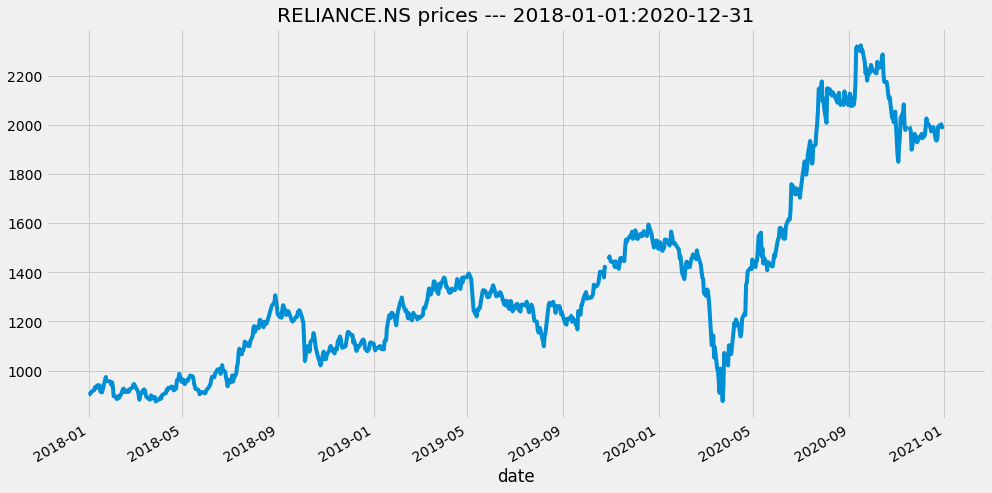

In [29]:
#DOWNLOADING DATA

def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));
    

download_csv_data(ticker='RELIANCE.NS', 
                  start_date='2018-01-01', 
                  end_date='2020-12-31', 
                  freq='daily', 
                  path='RELIANCE_test.csv')

In [30]:
!head RELIANCE_test.csv
!tail RELIANCE_test.csv

date,open,high,low,close
2018-01-01,914.0358276367188,914.0358276367188,898.9785766601562,901.2074584960938
2018-01-02,904.4269409179688,910.9154052734375,897.888916015625,902.5942993164062
2018-01-03,916.3142700195312,917.3048706054688,904.4764404296875,906.2100219726562
2018-01-04,909.528564453125,913.144287109375,907.1015625,911.6583862304688
2018-01-05,913.144287109375,918.1964111328125,911.60888671875,914.5806884765625
2018-01-08,917.4039306640625,922.2579345703125,914.828369140625,919.8309326171875
2018-01-09,919.4346923828125,935.0368041992188,915.3236694335938,932.114501953125
2018-01-10,934.145263671875,938.50390625,926.7156372070312,933.5013427734375
2018-01-11,932.9564819335938,933.7985229492188,926.2203369140625,928.9445190429688
2020-12-16,1988.0,1994.949951171875,1965.699951171875,1976.550048828125
2020-12-17,1984.5,2005.0,1977.1500244140625,1985.5999755859375
2020-12-18,1980.0999755859375,2004.9000244140625,1965.0,1991.550048828125
2020-12-21,2010.0,2022.0,1855.25,1939.6

In [46]:
# IMPORTING DATA

pd.options.display.float_format = '{:,.5f}'.format
reliance = pd.read_csv('RELIANCE_test.csv').set_index('date')
#reliance.loc[~(reliance==0).all(axis=1)]
reliance.tail()

,open,high,low,close
date,,,,
23-12-2020,"1,930.00000","1,951.44995","1,920.65002","1,943.84998"
24-12-2020,"1,947.00000","1,998.80005","1,945.90002","1,994.15002"
28-12-2020,"2,006.69995","2,018.00000","1,995.30005","2,003.30005"
29-12-2020,"2,009.00000","2,012.30005","1,982.55005","1,990.05005"
30-12-2020,"1,995.25000","2,007.19995","1,975.55005","1,995.50000"


In [47]:
#SMA CALCULATION

def sma(data, n):
    sma = data.rolling(window = n).mean()
    return pd.DataFrame(sma)

n = [20, 50]
for i in n:
    reliance[f'sma_{i}'] = sma(reliance['close'], i)

reliance.tail()

,open,high,low,close,sma_20,sma_50
date,,,,,,
23-12-2020,"1,930.00000","1,951.44995","1,920.65002","1,943.84998","1,969.26750","2,013.41800"
24-12-2020,"1,947.00000","1,998.80005","1,945.90002","1,994.15002","1,971.58500","2,007.68700"
28-12-2020,"2,006.69995","2,018.00000","1,995.30005","2,003.30005","1,974.12001","2,002.00300"
29-12-2020,"2,009.00000","2,012.30005","1,982.55005","1,990.05005","1,977.13251","1,997.67400"
30-12-2020,"1,995.25000","2,007.19995","1,975.55005","1,995.50000","1,979.16251","1,994.06800"


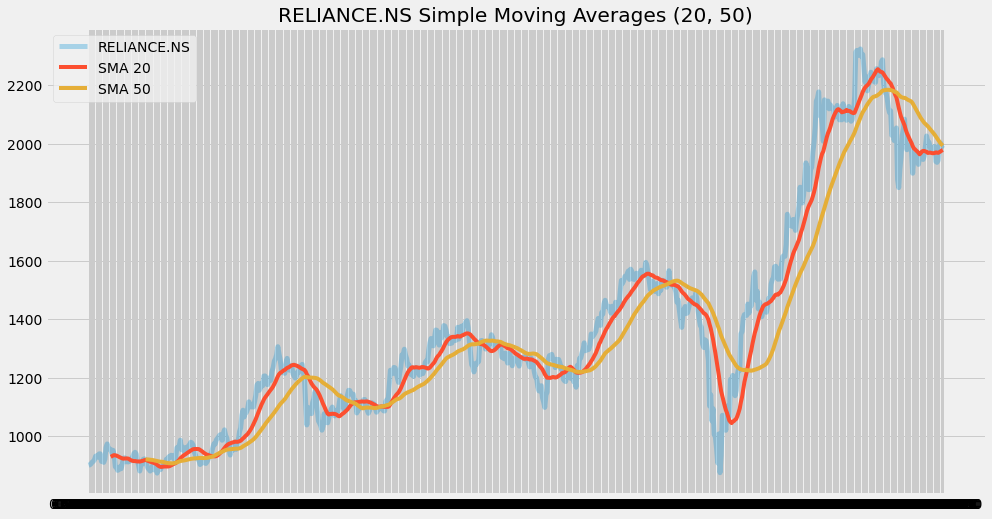

In [48]:
plt.plot(reliance['close'], label = 'RELIANCE.NS', linewidth = 5, alpha = 0.3)
plt.plot(reliance['sma_20'], label = 'SMA 20')
plt.plot(reliance['sma_50'], label = 'SMA 50')
plt.title('RELIANCE.NS Simple Moving Averages (20, 50)')
plt.legend(loc = 'upper left')
plt.show()

In [49]:
def implement_sma_strategy(data, short_window, long_window):
    sma1 = short_window
    sma2 = long_window
    buy_price = []
    sell_price = []
    sma_signal = []
    signal = 0
    
    for i in range(len(data)):
        if sma1[i] > sma2[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                sma_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        elif sma2[i] > sma1[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                sma_signal.append(-1)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            sma_signal.append(0)
            
    return buy_price, sell_price, sma_signal

sma_20 = reliance['sma_20']
sma_50 = reliance['sma_50']

buy_price, sell_price, signal = implement_sma_strategy(reliance['close'], sma_20, sma_50)
print(buy_price, sell_price, signal)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 960.9412231, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1006.013977, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

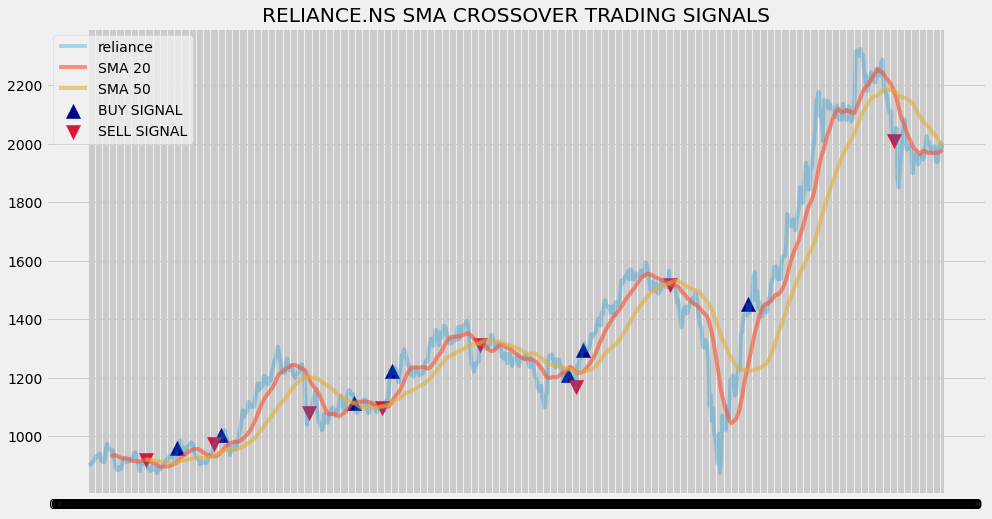

In [50]:
plt.plot(reliance['close'], alpha = 0.3, label = 'reliance')
plt.plot(sma_20, alpha = 0.6, label = 'SMA 20')
plt.plot(sma_50, alpha = 0.6, label = 'SMA 50')
plt.scatter(reliance.index, buy_price, marker = '^', s = 200, color = 'darkblue', label = 'BUY SIGNAL')
plt.scatter(reliance.index, sell_price, marker = 'v', s = 200, color = 'crimson', label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('RELIANCE.NS SMA CROSSOVER TRADING SIGNALS')
plt.show()

<AxesSubplot:>

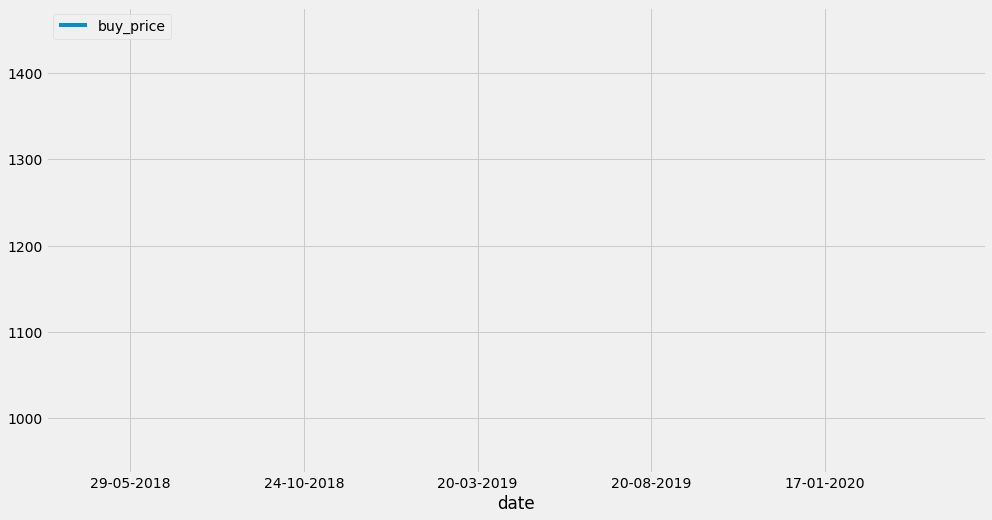

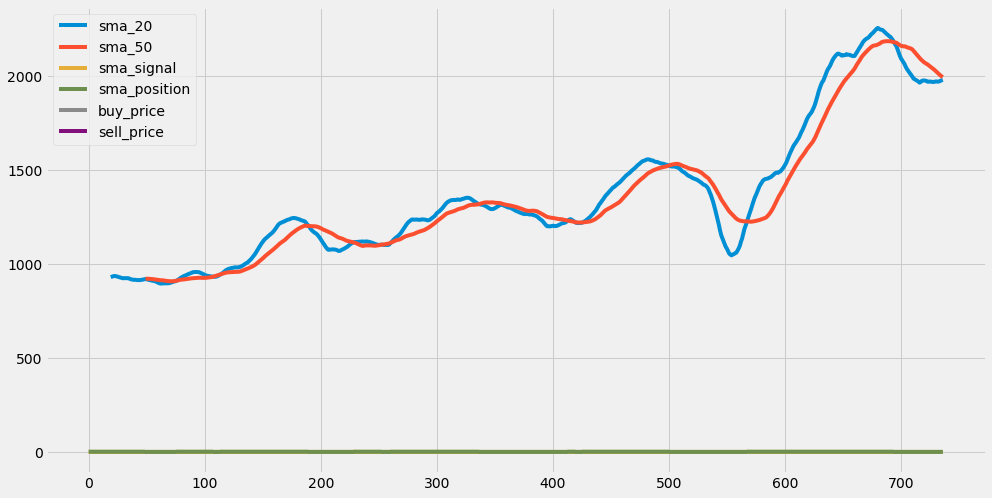

In [51]:
position = []

for i in range(len(signal)):
    if signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(reliance['close'])):
    if signal[i] == 1:
        position[i] = 1
    elif signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
sma_20 = pd.DataFrame(sma_20).rename(columns = {0:'sma_20'})
sma_50 = pd.DataFrame(sma_50).rename(columns = {0:'sma_50'})
signal_df = pd.DataFrame(signal).rename(columns = {0:'sma_signal'}).set_index(reliance.index)
position = pd.DataFrame(position).rename(columns = {0:'sma_position'}).set_index(reliance.index)

buy_price_df = pd.DataFrame(buy_price).rename(columns = {0:'buy_price'}).set_index(reliance.index)
sell_price_df = pd.DataFrame(sell_price).rename(columns = {0:'sell_price'}).set_index(reliance.index)

buy_price_df.plot()

frames = [sma_20, sma_50, signal_df, position, buy_price_df, sell_price_df]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index().drop('date', axis = 1)

strategy.plot()

In [52]:
# BACKTESTING THE STRATEGY

reliance_ret = pd.DataFrame(np.diff(reliance['close'])).rename(columns = {0:'returns'})
sma_strategy_ret = []

for i in range(len(reliance_ret)):
    try:
        returns = reliance_ret['returns'][i]*strategy['sma_position'][i]
        sma_strategy_ret.append(returns)
    except:
        pass
    
sma_strategy_ret_df = pd.DataFrame(sma_strategy_ret).rename(columns = {0:'sma_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/reliance['close'][1])
sma_investment_ret = []

for i in range(len(sma_strategy_ret_df['sma_returns'])):
    returns = number_of_stocks*sma_strategy_ret_df['sma_returns'][i]
    sma_investment_ret.append(returns)

sma_investment_ret_df = pd.DataFrame(sma_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(sma_investment_ret_df['investment_returns']), 2)

benchmark_price = 100000*((reliance['close'].iloc[len(reliance)-1]/reliance['close'].iloc[0])-1)
print(reliance['close'].iloc[len(reliance)-1], reliance['close'].iloc[0])
print(f'Benchmark profit: {benchmark_price}')

print(cl('Profit gained from the strategy by investing ₹100K in RELIANCE.NS : ₹{}'.format(total_investment_ret), attrs = ['bold']))


1995.5 901.2074585
Benchmark profit: 121425.15368452203
Profit gained from the strategy by investing ₹100K in RELIANCE.NS : ₹101052.46
